In [ ]:
from modelparts.loadData import ExDark
from modelparts.modelStructure import UNet
from modelparts.loss import calculate_loss
from modelparts.loadData import ExDark, ExDarkDataset, custom_collate_fn
from modelparts.modelStructure import UNet
from modelparts.validation import validate_epoch
from modelparts.yolo import init_yolo, yolo_object

ImportError: cannot import name 'UNet2' from 'modelparts.modelStructure' (/Users/dannidahl/Documents/GitHub/P3/modelparts/modelStructure.py)

Using device: cpu
Epoch [10/250], Loss: 0.062216
Epoch [20/250], Loss: 0.041262
Epoch [30/250], Loss: 0.027240
Epoch [40/250], Loss: 0.017612
Epoch [50/250], Loss: 0.011243
Epoch [60/250], Loss: 0.007120
Epoch [70/250], Loss: 0.004599
Epoch [80/250], Loss: 0.003121
Epoch [90/250], Loss: 0.002201
Epoch [100/250], Loss: 0.001625
Epoch [110/250], Loss: 0.001241
Epoch [120/250], Loss: 0.000981
Epoch [130/250], Loss: 0.000795
Epoch [140/250], Loss: 0.000670
Epoch [150/250], Loss: 0.000614
Epoch [160/250], Loss: 0.000507
Epoch [170/250], Loss: 0.000432
Epoch [180/250], Loss: 0.000377
Epoch [190/250], Loss: 0.000334
Epoch [200/250], Loss: 0.000300
Epoch [210/250], Loss: 0.000272
Epoch [220/250], Loss: 0.000249
Epoch [230/250], Loss: 0.000230
Epoch [240/250], Loss: 0.000228
Epoch [250/250], Loss: 0.000197


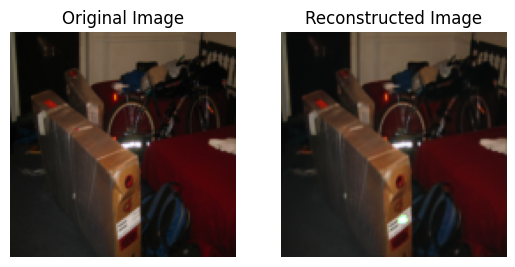

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Dummy Dataset that always returns the same image
class SingleImageDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.image = Image.open(image_path).convert("RGB")
        self.transform = transform

    def __len__(self):
        return 1  

    def __getitem__(self, idx):
        if self.transform:
            img = self.transform(self.image)
        return img, img 

# Test function
def test_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    dataset = SingleImageDataset("DatasetExDark/ExDark_images/2015_00001.png", transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Initialize model, loss, and optimizer
    model = UNet(in_channels=3, out_channels=3).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Training Loop
    num_epochs = 250
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Print loss for monitoring
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")
    
    # Test output
    model.eval()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            # Plot original and reconstructed images
            plt.subplot(1, 2, 1)
            plt.title("Original Image")
            plt.imshow(inputs.cpu().squeeze(0).permute(1, 2, 0))
            plt.axis("off")
            
            plt.subplot(1, 2, 2)
            plt.title("Reconstructed Image")
            plt.imshow(outputs.cpu().squeeze(0).permute(1, 2, 0))
            plt.axis("off")
            
            plt.show()
            break

# Run the test
test_model()

In [31]:
import time
import numpy as np

def measure_inference_time(model, dataloader, device, num_runs=1000):
    model.eval()
    times = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            
            # Run the inference num_runs times
            for _ in range(num_runs):
                start_time = time.time()
                _ = model(inputs)
                elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
                times.append(elapsed_time)
    avg_time = np.mean(times)
    print(f"Average Inference Time: {avg_time:.6f} ms")
    return avg_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load and preprocess image
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
dataset = SingleImageDataset("DatasetExDark/ExDark_images/2015_00001.png", transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize model
model = UNet(in_channels=3, out_channels=3).to(device)

# Assuming the model is already trained here (call train loop if not)

# Measure inference time
avg_inference_time = measure_inference_time(model, dataloader, device, num_runs=1000)

Using device: cpu
Average Inference Time: 96.189296 ms


In [5]:
class Config:
    def __init__(self):
        self.class_filter = []
        self.light_filter = None
        self.location_filter = None
        self.target_size = (640, 640)
        self.batch_size = 32
        self.num_workers = 8
        self.class_ids = [1, 8, 39, 5, 2, 15, 56, 41, 16, 3, 0, 60]

config = Config()
config.class_filter = [1, 2]

dataset = ExDark(filepath="DatasetExDark")
image_paths = dataset.load_image_paths_and_classes(config, split_filter=[1])[:100]

print(f"billeder fundet: {len(image_paths)}")


billeder fundet: 100


In [6]:
validation_dataset = ExDarkDataset(dataset, image_paths, config.target_size)
print(f"{validation_dataset}")

validation_loader = DataLoader(
    validation_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    collate_fn=custom_collate_fn
)

print(f"{validation_loader}")


Batch 1, Loss: 6.509684085845947
Batch 2, Loss: 6.046971797943115
Batch 3, Loss: 6.80979585647583
Batch 4, Loss: 4.7793049812316895


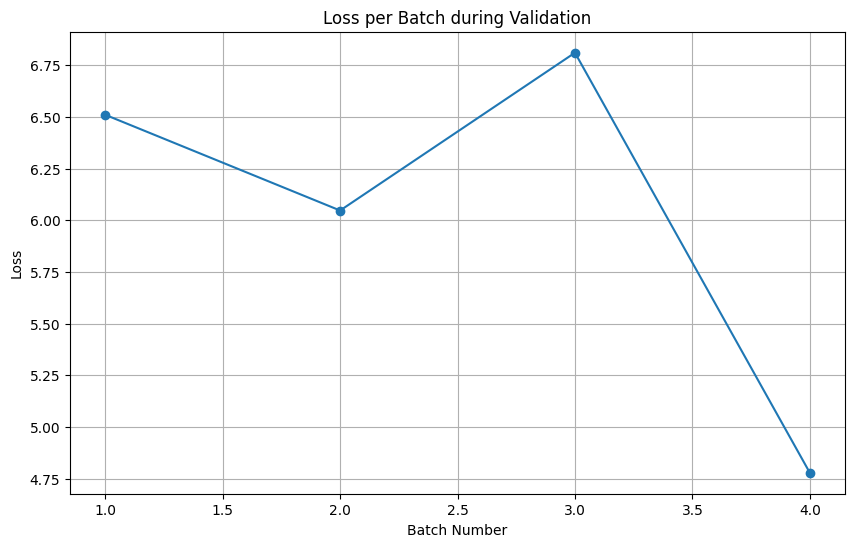

In [7]:
yolo_model = init_yolo([1, 8, 39, 5, 2, 15, 56, 41, 16, 3, 0, 60])

# List to store batch losses
batch_losses = []

# Iterate through validation batches
for batch_idx, batch in enumerate(validation_loader):
    image = batch['image']
    ground_truth = batch['ground_truth']
    
    # Optional: Apply image enhancement (if any)
    enhanced_image = image
    
    # Calculate loss
    loss = calculate_loss(enhanced_image, ground_truth, yolo_model)
    normalized_loss = loss / len(image)
    
    # Append the loss to the list
    batch_losses.append(normalized_loss.item())  # Assuming `loss` is a torch.Tensor
    
    # Print progress (optional)
    print(f"Batch {batch_idx + 1}, Loss: {normalized_loss.item()}")

# Plot the batch losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(batch_losses) + 1), batch_losses, marker='o', linestyle='-')
plt.title("Loss per Batch during Validation")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import torch

def plot_predictions_and_ground_truth(images, predictions, ground_truths, num_images=12):
    """
    Plots 12 random images with predictions and ground truth boxes, scaling coordinates properly.
    """
    assert len(images) == len(predictions) == len(ground_truths), \
        "Images, predictions, and ground truths must have the same length."

    # Ensure we have enough images
    if len(images) < num_images:
        num_images = len(images)

    # Randomly select indices
    indices = random.sample(range(len(images)), num_images)

    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        ax = axes[i]
        img = images[idx].permute(1, 2, 0).cpu().numpy()  # Convert to HWC
        H, W, _ = img.shape  # Image height and width

        # Display the image
        ax.imshow(img)
        ax.axis("off")

        # Ground truth boxes
        for gt_box, label in zip(ground_truths[idx]["boxes"], ground_truths[idx]["labels"]):
            x_min, y_min, x_max, y_max = gt_box.tolist()
            # Scale coordinates to image size
            x_min, x_max = x_min * W, x_max * W
            y_min, y_max = y_min * H, y_max * H
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor="green", facecolor="none"
            )
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5, f"GT: {label}", color="green", fontsize=10)

        # Prediction boxes
        for pred_box, label, score in zip(predictions[idx]["boxes"], 
                                          predictions[idx]["labels"], 
                                          predictions[idx]["scores"]):
            x_min, y_min, x_max, y_max = pred_box.tolist()
            # Scale coordinates to image size
            x_min, x_max = x_min * W, x_max * W
            y_min, y_max = y_min * H, y_max * H
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor="red", facecolor="none"
            )
            ax.add_patch(rect)
            ax.text(x_min, y_min - 15, f"Pred: {label} ({score:.2f})", color="red", fontsize=10)

    # Hide remaining axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

{'map': tensor(0.1450), 'map_50': tensor(0.3132), 'map_75': tensor(0.1482), 'map_small': tensor(0.1450), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.1151), 'mar_10': tensor(0.1625), 'mar_100': tensor(0.1625), 'mar_small': tensor(0.1625), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor([0.3376, 0.3087, 0.0787, 0.0000, 0.0000]), 'mar_100_per_class': tensor([0.3750, 0.3519, 0.0857, 0.0000, 0.0000]), 'classes': tensor([ 0,  1,  2,  5, 56], dtype=torch.int32)}


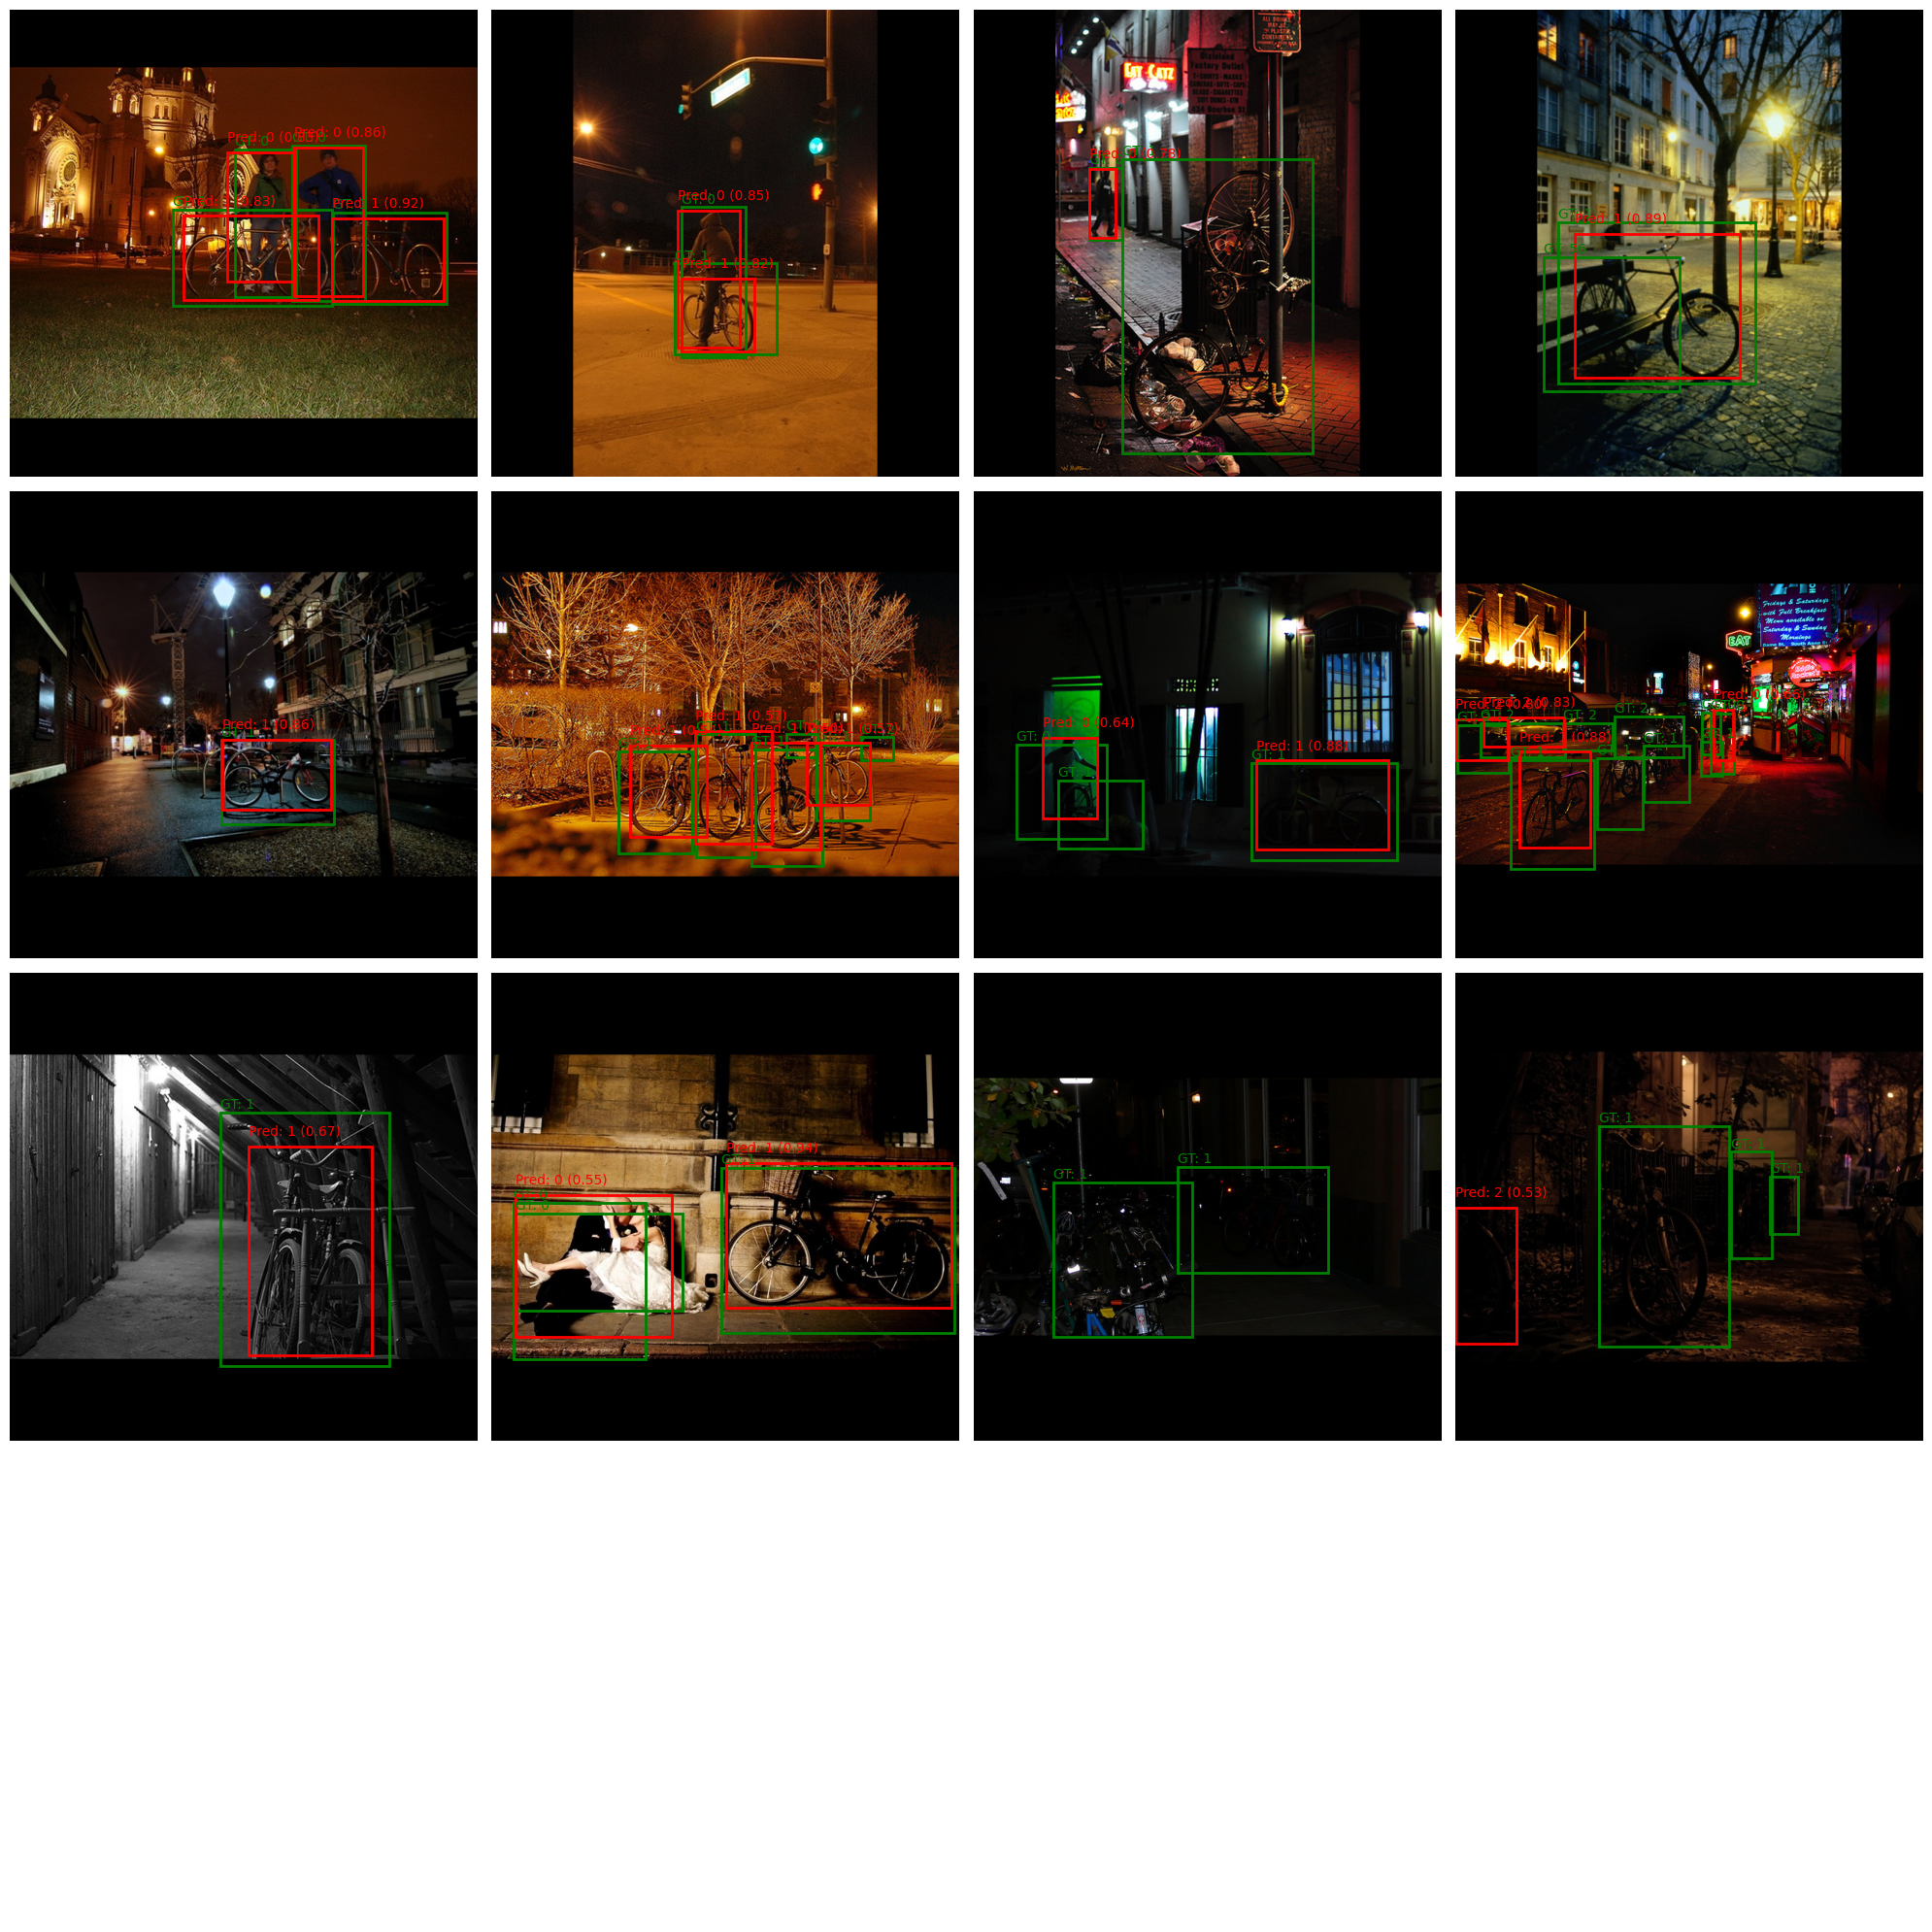

In [20]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from ultralytics import YOLO

# Initialize the mAP metric
map_metric = MeanAveragePrecision(class_metrics=True)

yolo_model = YOLO("yolo11n.pt")


# Lists to accumulate data for plotting
accumulated_images = []
accumulated_predictions = []
accumulated_ground_truths = []

# Iterate over the validation dataset
for batch_idx, batch in enumerate(validation_loader):
    images = batch['image']  # Tensor of shape [B, C, H, W]
    ground_truths = batch['ground_truth']  # List of length B
    
    # Get model predictions
    yolo_outputs = yolo_object(images, yolo_model, config.target_size, config.class_ids)
    
    # Iterate over each image in the batch
    for i in range(images.size(0)):
        predictions = yolo_outputs[i]
        gt = ground_truths[i]
        
        # Convert Ground Truth to mAP format
        gt_boxes = []
        gt_labels = []
        for obj in gt:
            label, cx, cy, width, height = obj
            x_min = cx - width / 2
            y_min = cy - height / 2
            x_max = cx + width / 2
            y_max = cy + height / 2
            gt_boxes.append([x_min, y_min, x_max, y_max])
            gt_labels.append(label)
        
        gt_data = {
            "boxes": torch.tensor(gt_boxes, dtype=torch.float32),
            "labels": torch.tensor(gt_labels, dtype=torch.int64),
        }
        
        # Convert Predictions to mAP format
        pred_boxes = []
        pred_scores = []
        pred_labels = []
        for pred in predictions:
            pred_boxes.append(pred['bbox'])
            pred_scores.append(pred['confidence'])
            pred_labels.append(pred['class_id'])
        
        pred_data = {
            "boxes": torch.tensor(pred_boxes, dtype=torch.float32),
            "scores": torch.tensor(pred_scores, dtype=torch.float32),
            "labels": torch.tensor(pred_labels, dtype=torch.int64),
        }
        
        # Update mAP metric
        map_metric.update([pred_data], [gt_data])
        
        # Accumulate data for plotting
        accumulated_images.append(images[i])
        accumulated_predictions.append(pred_data)
        accumulated_ground_truths.append(gt_data)
    
    # Optional: Break early if enough samples are collected
    if len(accumulated_images) >= 12:
        break

# Compute mAP after all batches
map_result = map_metric.compute()
print(map_result)

# Randomly select 12 samples for plotting
if len(accumulated_images) >= 12:
    plot_predictions_and_ground_truth(
        accumulated_images,
        accumulated_predictions,
        accumulated_ground_truths,
        num_images=12
    )
else:
    print("Not enough samples to plot 12 images.")